In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
img_path = r"data/tobacco/Image_2022_0716_1409_08_547-001482.bmp"

In [6]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

In [257]:
l_bmax = 43
l_bmin = 1
a_bmax = 148
a_bmin = 122
b_bmax = 137
b_bmin = 126

In [258]:
l_ymax = 157
l_ymin = 6
# l_ymin = 44
a_ymax = 170
a_ymin = 124
b_ymax = 163
b_ymin = 129

In [259]:
# item_mask = np.zeros((1024, 4096))
item_mask = ~((img[:,:,0]>=l_bmin)&(img[:,:,0]<=l_bmax)&(img[:,:,1]>=a_bmin)&(img[:,:,1]<=a_bmax)&(img[:,:,2]>=b_bmin)&(img[:,:,2]<=b_bmax))+0

In [260]:
# tobacco_mask = np.zeros((1024, 4096))
tobacco_mask = ((img[:,:,0]>=l_ymin)&(img[:,:,0]<=l_ymax)&(img[:,:,1]>=a_ymin)&(img[:,:,1]<=a_ymax)&(img[:,:,2]>=b_ymin)&(img[:,:,2]<=b_ymax))+0

In [262]:
mask = (item_mask.all() & tobacco_mask.all())


TypeError: Invalid shape () for image data

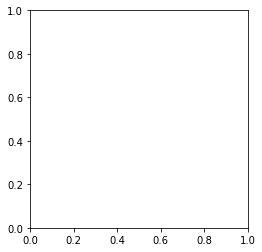

In [265]:
fig,ax = plt.subplots()
ax = plt.imshow(mask)
plt.show()

In [264]:
c = mask.max(axis=0).max(axis=0)
d = mask.min(axis=0).max(axis=0)